In [6]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

# prepare dataset

In [7]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),])

test_transform = transforms.Compose([
    transforms.ToTensor(),])

In [8]:
# train sets
trainset = datasets.MNIST('/.data', download=True, train=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# test sets
testset = datasets.MNIST('/.data', download=True, train=False, transform=test_transform)
testloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

#check
len(trainloader)

938

# Visualize model

In [9]:
data = next(iter(trainloader))
images, labels = data

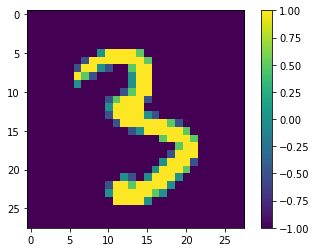

In [15]:
plt.figure()
plt.imshow(np.squeeze(images[0]))
plt.colorbar()
plt.grid(False)
plt.show()

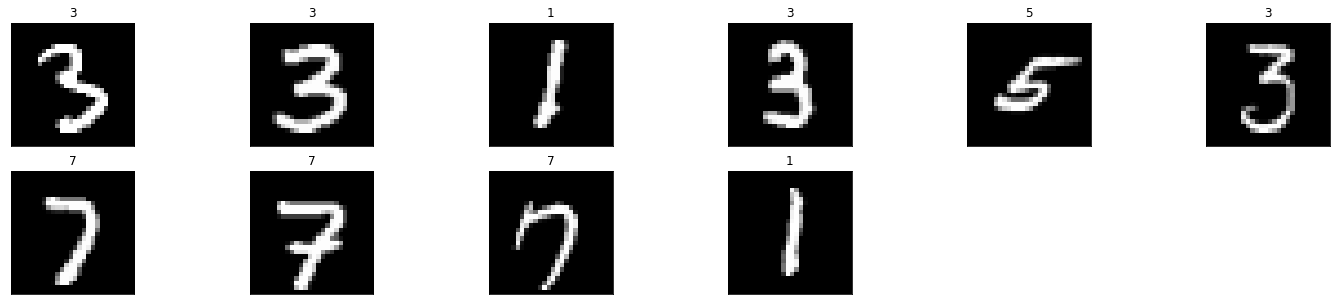

In [10]:
fig = plt.figure(figsize=(25, 5))

for i in range(10):
    ax = fig.add_subplot(2, 6, i+1, xticks=[], yticks=[])
    img = images[i]
    img = np.squeeze(img)
    ax.imshow(img, cmap='gray')
    ax.set_title(str(labels[i].item()))

# Define Network

In [9]:
from torch import nn


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Linear(28 * 28, 512)
        self.layer2 = nn.Linear(512, 128)
        self.layer3 = nn.Linear(128, 10)
        self.drop = nn.Dropout(p=0.2)

    def forward(self, x):
        # Flatten
        x = x.view(x.shape[0], -1)
        x = self.drop(F.relu(self.layer1(x)))
        x = self.drop(F.relu(self.layer2(x)))
        x = self.layer3(x)
        return F.log_softmax(x, dim=1)


# Network summery

In [10]:
from torchsummary import summary

# create model
model = Net()
# print summery
summary(model, (28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 512]         401,920
           Dropout-2                  [-1, 512]               0
            Linear-3                  [-1, 128]          65,664
           Dropout-4                  [-1, 128]               0
            Linear-5                   [-1, 10]           1,290
Total params: 468,874
Trainable params: 468,874
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 1.79
Estimated Total Size (MB): 1.80
----------------------------------------------------------------


# Hyperparameters

In [11]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training

In [14]:
# number of epochs to train the model
n_epochs = 6

# initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

#Track time
since = time.time()

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0.0
    correct = 0.0
    
    ###################
    # train the model #
    ###################
    model.train() # prep model for training
    for data, target in trainloader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval() # prep model for evaluation
    for data, target in testloader:
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update running validation loss 
        valid_loss += loss.item()*data.size(0)
        # calculate accuracy
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
    # print training/validation statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(trainloader.sampler)
    valid_loss = valid_loss/len(testloader.sampler)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy {:.2f}'.format(
        epoch+1, 
        train_loss,
        valid_loss, (correct/total)*100
        ))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.145493 	Validation Loss: 0.090382 	Accuracy 97.20
Validation loss decreased (inf --> 0.090382).  Saving model ...
Epoch: 2 	Training Loss: 0.126870 	Validation Loss: 0.074755 	Accuracy 97.62
Validation loss decreased (0.090382 --> 0.074755).  Saving model ...
Epoch: 3 	Training Loss: 0.111933 	Validation Loss: 0.069094 	Accuracy 97.78
Validation loss decreased (0.074755 --> 0.069094).  Saving model ...
Epoch: 4 	Training Loss: 0.106152 	Validation Loss: 0.055734 	Accuracy 98.24
Validation loss decreased (0.069094 --> 0.055734).  Saving model ...
Epoch: 5 	Training Loss: 0.099086 	Validation Loss: 0.059481 	Accuracy 98.18
Epoch: 6 	Training Loss: 0.093487 	Validation Loss: 0.055528 	Accuracy 98.23
Validation loss decreased (0.055734 --> 0.055528).  Saving model ...


# Load Best model

In [15]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

# Testing

In [18]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in testloader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(len(target)):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(testloader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %2s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.055528

Test Accuracy of  0: 99% (5896/5923)
Test Accuracy of  1: 99% (6715/6742)
Test Accuracy of  2: 98% (5861/5958)
Test Accuracy of  3: 97% (5971/6131)
Test Accuracy of  4: 98% (5750/5842)
Test Accuracy of  5: 96% (5258/5421)
Test Accuracy of  6: 99% (5876/5918)
Test Accuracy of  7: 98% (6174/6265)
Test Accuracy of  8: 98% (5739/5851)
Test Accuracy of  9: 95% (5697/5949)

Test Accuracy (Overall): 98% (58937/60000)


# Visualize Test Result

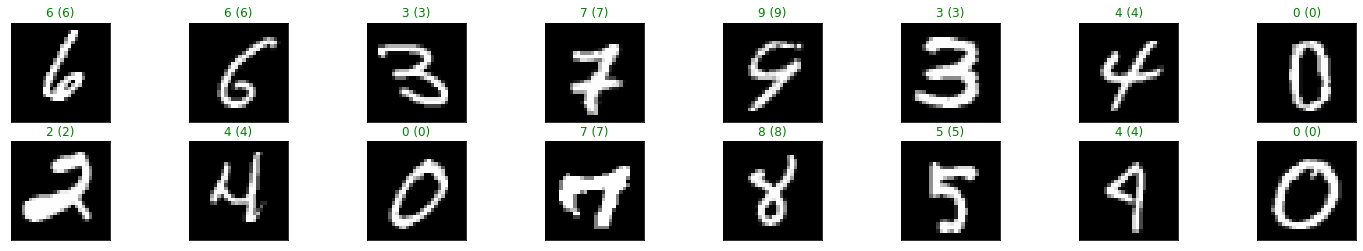

In [23]:
# obtain one batch of test images
dataiter = iter(testloader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))